

# pytorch : Vanilla CNN

https://medium.com/@inmoonlight/pytorch%EB%A1%9C-%EB%94%A5%EB%9F%AC%EB%8B%9D%ED%95%98%EA%B8%B0-cnn-62a9326111ae

In [8]:
import itertools # 효율적인 looping을 위한 이터레이션을 만드는 함수
from IPython.display import Image
from IPython import display # 리눅스 쉘과 같이 이용할 수 있도록 기능이 추가된 파이썬. 주피터는 IPython Notebook
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

In [12]:
import os
print(os.getcwd())

train_dataset = datasets.MNIST('../mnist_data/',
                               download=True,
                               train=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(), # Image to Tensor
                                   transforms.Normalize((0.1307,),(0.3081,))
                               ]))
val_dataset = datasets.MNIST("../mnist_data/", 
                             download=False,
                             train=False,
                             transform= transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307, ),(0.3081, ))
                           ]))

c:\Users\아로미\practice\CV


100%|██████████| 9912422/9912422 [00:00<00:00, 13647103.99it/s]


Extracting ../mnist_data/MNIST\raw\train-images-idx3-ubyte.gz to ../mnist_data/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 14484717.66it/s]


Extracting ../mnist_data/MNIST\raw\train-labels-idx1-ubyte.gz to ../mnist_data/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 5604345.62it/s]


Extracting ../mnist_data/MNIST\raw\t10k-images-idx3-ubyte.gz to ../mnist_data/MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4555363.17it/s]

Extracting ../mnist_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ../mnist_data/MNIST\raw



In [13]:
# batch iterator
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size = batch_size,
                                         shuffle = True)

# CNN modeling

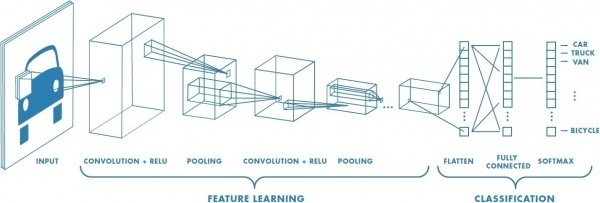

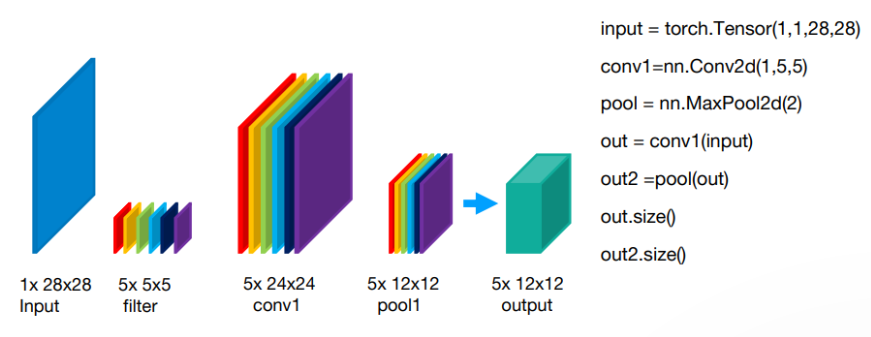

In [18]:
# construct model on cuda if possible
use_cuda = torch.cuda.is_available()

class CNNClassifier(nn.Module):
    
    def __init__(self):
        # 항상 torch.nn.Module을 상속받고 시작
        super(CNNClassifier, self).__init__()
        # input : 1@28*28, output: 6@24*24 (28-kernel_size=5+1=24)
        conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1)
        # activation ReLU
        pool1 = nn.MaxPool2d(2) # 6@12*12 # stride(default = kernel_size)
        # input : 6@12*12, output: 16@8*8 (12-kernel_size=5+1=8)
        conv2 = nn.Conv2d(6,16,5,1) 
        # activation ReLU
        pool2 = nn.MaxPool2d(2) # 16@4*4
        
        # Convolution Layer
        self.conv_module = nn.Sequential(
            conv1, 
            nn.ReLU(),
            pool1,
            conv2,
            nn.ReLU(),
            pool2
        )
        
        fc1 = nn.Linear(16*4*4, 120)
        # activation ReLU
        fc2 = nn.Linear(120,84)
        # activation ReLU
        fc3 = nn.Linear(84,10)
        
        # FCN
        self.fc_module = nn.Sequential(
            fc1,
            nn.ReLU(),
            fc2,
            nn.ReLU(),
            fc3
        )
        
        if use_cuda:
            self.conv_module = self.self.conv_module.cuda()
            self.fc_module = self.fc_module.cuda()
    
    def forward(self, x):
        out = self.conv_module(x) # 16@4*4
        # make linear
        dim = 1
        for d in out.size()[1:]: # 16, 4, 4
            dim = dim * d
        out = out.view(-1, dim) # Flatten 1*(16*4*4=256)
        out = self.fc_module(out)
        return F.softmax(out,dim=1)
        

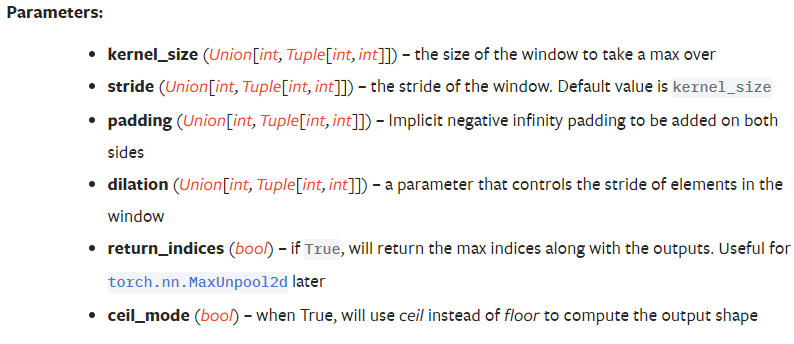

### Purpose of Pooling (원리)

1. input size를 줄임(Down Sampling).

: 텐서의 크기를 줄이는 역할을 한다.

2. overfitting을 조절

: input size가 줄어드는 것은 그만큼 쓸데없는 parameter의 수가 줄어드는 것이라고 생각할 수 있다. 훈련데이터에만 높은 성능을 보이는 과적합(overfitting)을 줄일 수 있다.

3. 특징을 잘 뽑아냄.

: pooling을 했을 때, 특정한 모양을 더 잘 인식할 수 있음.

4. 지역적 이동에 노이즈를 줌으로써 일반화 성능을 올려준다. maxpooling의 경우 주어진 픽셀중 큰것만 뽑기때문에 모양이 조금 달라지는 특성을 가지고 있다.


# Instantiate

In [19]:
cnn = CNNClassifier()

# Train

In [44]:
# loss
criterion = nn.CrossEntropyLoss()
# backpropagation method
lr = 1e-3
optimizer = optim.Adam(cnn.parameters(), lr=lr)
# hyper-parameters
num_epochs = 2
num_batches = len(train_loader)

train_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    train_loss = 0.0
    for i, data in enumerate(train_loader): 
        # train_lodaer의 row는 (x, label)로 이루어짐
        x, label = data
        if use_cuda:
            x = x.cuda()
            label = label.cuda()
        
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = cnn(x)
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation
        loss.backward()
        # weight update
        optimizer.step()
        
        # train_loss summary
        train_loss += loss.item() # tensor에 저장된 value만을 가져온다.
        
        # del (memory issue)
        del loss
        del model_output
        
        # 학습과정 출력
        if (i+1) % 100 == 0: # every 100 mini-batches
            # Pytorch는 autograd engine을 꺼버린다. 
            # 이 말은 더 이상 자동으로 gradient를 트래킹하지 않는다는 말이 된다.
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                for j, val in enumerate(val_loader):
                    val_x, val_label = val
                    if use_cuda:
                        val_x = val_x.cuda()
                        val_label = val_label.cuda()
                    val_output = cnn(val_x)
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
            
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, train_loss/100, val_loss/len(val_loader)
            ))
            
            train_loss_list.append(train_loss/100)
            val_loss_list.append(val_loss/len(val_loader))
            train_loss = 0.0
            

epoch: 1/2 | step: 100/938 | trn loss: 1.5855 | val loss: 1.5952
epoch: 1/2 | step: 200/938 | trn loss: 1.5385 | val loss: 1.5008
epoch: 1/2 | step: 300/938 | trn loss: 1.4988 | val loss: 1.4875
epoch: 1/2 | step: 400/938 | trn loss: 1.4905 | val loss: 1.4888
epoch: 1/2 | step: 500/938 | trn loss: 1.4943 | val loss: 1.4899
epoch: 1/2 | step: 600/938 | trn loss: 1.4895 | val loss: 1.4980
epoch: 1/2 | step: 700/938 | trn loss: 1.4963 | val loss: 1.4966
epoch: 1/2 | step: 800/938 | trn loss: 1.4871 | val loss: 1.4935
epoch: 1/2 | step: 900/938 | trn loss: 1.4874 | val loss: 1.4819
epoch: 2/2 | step: 100/938 | trn loss: 1.4829 | val loss: 1.4827
epoch: 2/2 | step: 200/938 | trn loss: 1.4813 | val loss: 1.4827
epoch: 2/2 | step: 300/938 | trn loss: 1.4899 | val loss: 1.4850
epoch: 2/2 | step: 400/938 | trn loss: 1.4863 | val loss: 1.4801
epoch: 2/2 | step: 500/938 | trn loss: 1.4879 | val loss: 1.4795
epoch: 2/2 | step: 600/938 | trn loss: 1.4852 | val loss: 1.4788
epoch: 2/2 | step: 700/93

In [46]:
print(f"train loss is... {round(train_loss,2)}")
print(f"val loss is... {round(val_loss.item(),2)}", )
print('length of total dataset is...{}'.format(len(train_dataset+val_dataset)))

train loss is... 56.52
val loss is... 232.16
length of total dataset is...70000


In [48]:
print(len(train_loader))
print(len(train_dataset)/batch_size)

938
937.5


Text(0, 0.5, 'loss')

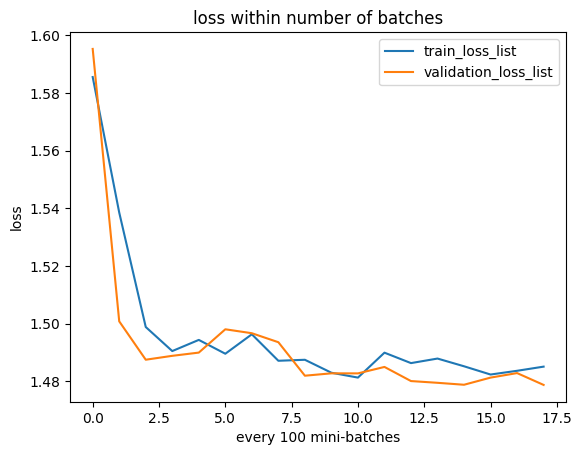

In [60]:
# plt.figure(figsize=(20,10))
plt.plot(train_loss_list, label = "train_loss_list")
plt.plot(val_loss_list, label = "validation_loss_list")
plt.legend()
plt.title("loss within number of batches")
plt.xlabel("every 100 mini-batches")
plt.ylabel("loss")
